# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

##  Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#Соххраним наши данные в нужные нам переменные 
df_1= pd.read_csv('/datasets/geo_data_0.csv') 
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

data = {0:df_1, 1:df_2, 2:df_3}

display(df_1.head())
display(df_2.head())
display(df_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В таблицах представленны необходимые нам данные. Среди столбцов имеется id - обозначение каждой точки, три параметра f0, f1, f2 - они обозначают значимые признаки точек, и product - объём запасов в скважине (тыс. баррелей). product является целевым признаком, f0, f1, f2 - обучающие признаки.

In [4]:
#Проверим общую информацию
for reg, df in data.items():
    print('Region', reg+1, '\n', '-' * 15)
    df.info()
    print()

Region 1 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 2 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 3 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

Пропусков нет, тип данных верный. Колличество строк в таблицах совпадает.

In [5]:
# Посмотрим на дубликаты
for reg, df in data.items():
    print(f'Region {reg+1}',
          '-' * 15,
          f'duplicated   {df.duplicated().sum()}',
          df[['id']].nunique(), sep='\n', end='\n\n')

Region 1
---------------
duplicated   0
id    99990
dtype: int64

Region 2
---------------
duplicated   0
id    99996
dtype: int64

Region 3
---------------
duplicated   0
id    99996
dtype: int64



Полных дубликатов нет,но есть повторения в id в каждом регионе. Это может указывать на несколько измерений некоторых точек в разное время. Удалять их пока не будем.

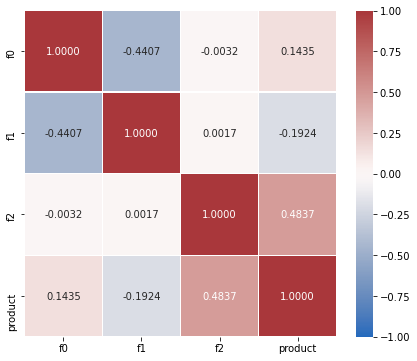

In [6]:
# Посмотрим на корреляцию. Для удобства создадим функцию.
def describe_df(data):
    df = data[1]
    plt.figure(figsize=(7, 6))
    sns.heatmap(df.corr(), linewidths=.5, cmap='vlag', annot=True, fmt='2.4f', vmin=-1)
    plt.show()
    
desc_corr = (describe_df(df) for df in data.items())

# Матрица корреляций для 1 Региона
next(desc_corr)   

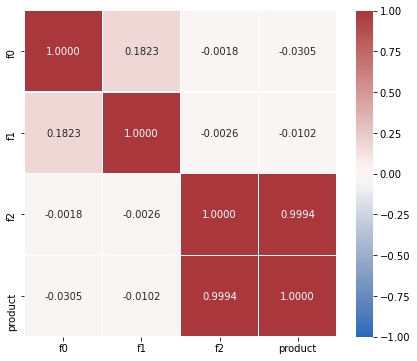

In [7]:
# Матрица корреляций для 2 Региона
next(desc_corr) 

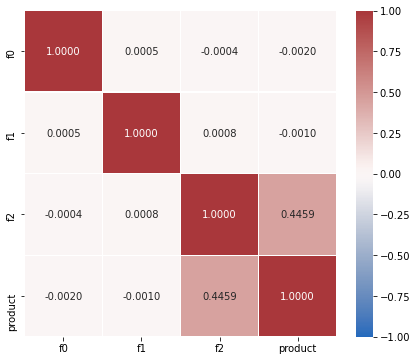

In [8]:
# Матрица корреляций для 3 Региона
next(desc_corr)

Матрица корреляций показала, что в первом и третьем регионах есть средняя положительная зависимость f2 от product, в первом регионе также есть средняя отрицательная корреляция между f1 и f0. <br>
Но во втором регионе заметна сильная положительная зависимость ( практически 1) f2 от product. Этот регион нужно тчательно проверить.

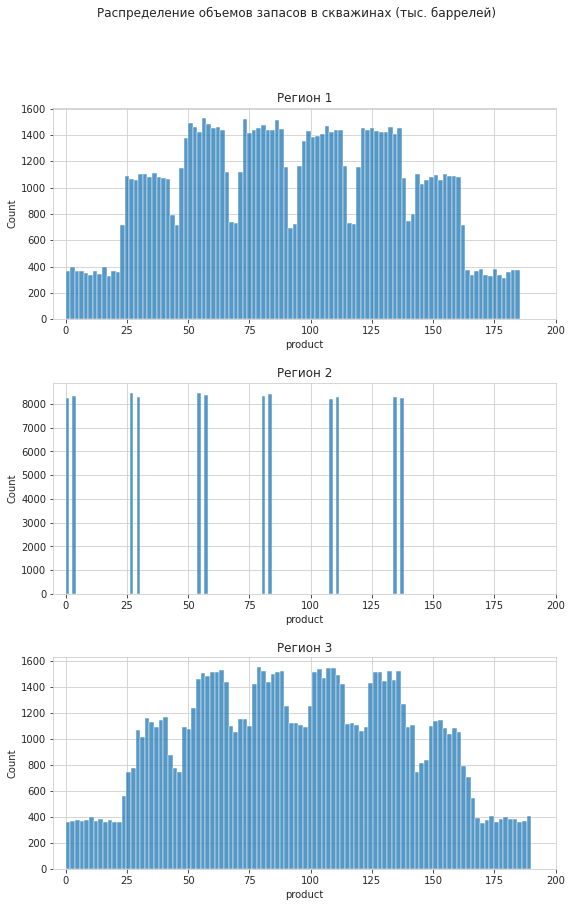

In [9]:
# Посмотрим на распредлиение объемов запасов в скважинах
sns.set_style("whitegrid", {'ytick.left': True, 'xtick.bottom':True}) 
fig, ax = plt.subplots(3, 1, figsize=(9, 14))
plt.subplots_adjust(hspace=0.3)

for reg, df in data.items():
    sns.histplot(df['product'], ax=ax[reg], bins=100)
    ax[reg].set_title(f'Регион {reg+1}')
    ax[reg].set_xlim(-5, 200)
    
fig.suptitle('Распределение объемов запасов в скважинах (тыс. баррелей)')
plt.show()

Все три региона имеют 6 пиков, этому может быть объяснение: <br>
- Данные принадлежат точкам, где запасы нефти превышают объем других точек.
- Специфическая методика измерения запасов. Какие-то параметры могут сильно влиять на общие данные запаса нефти.
- В нашем случае, данные синтезированы, поэтому графики могут выглядеть достаточно красиво.

График для второго региона показывает слишком "точные" данные. Рассмотрим еще один график для большего понятия ситуации.

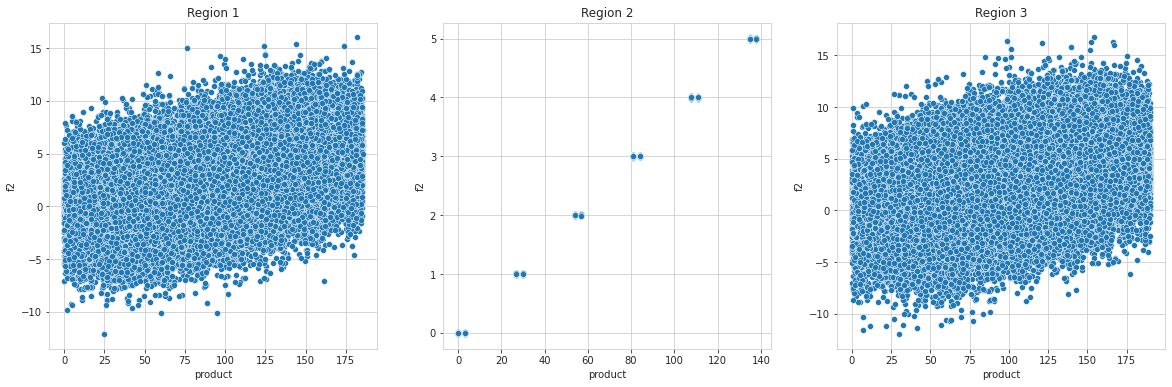

In [10]:
# Рассмотрим график рассеивания
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.scatterplot(data=data[0], x='product', y='f2', ax=ax[0])
ax[0].set_title('Region 1')
sns.scatterplot(data=data[1], x='product', y='f2', ax=ax[1])
ax[1].set_title('Region 2')
sns.scatterplot(data=data[2], x='product', y='f2', ax=ax[2])
ax[2].set_title('Region 3')
plt.show()


По нашим графикам видно, что 1 и 3 регионы имеют случайное распределение, в то время, как во 2 регионе явная прямолинейная зависимость. Также видно, что имеется 6 точек замера ( видимо по 2 пробы).

###  Вывод

<b> В ходе исследования и подготовки данных мы выявили, что данные во втором регионе являются дискретными и имеют прямолинейную зависимость. Такие данные не имеют смысла в применении в обучение модели, так как всегда будут выдавать целевой признак. Но все равно мы их используем.</b>

## Обучение и проверка модели

###  Разделение на выборки

In [11]:
# Для каждого региона посчитаем метрики
metrics_data = {'r2':[], 'rmse':[], 'predicted_mean':[], 'target_mean':[]}
region_predictions = []

# Для этого построим цикл, где разделим данные на целевой признак и признаки
for reg, df in data.items():
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    # Разделим данные на обучающую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    # Обучим модель с помощью Линейной Регрессии 
    model = LinearRegression()
    model.fit(features_train, target_train)  
    
    # Посчитаем метрики RMSE, R2 и prediction(точность)
    predictions = model.predict(features_valid)
    region_predictions.append(pd.Series(index=target_valid.index, data=predictions))
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    # Сохраним метрики в таблице
    metrics_data['r2'].append(r2_score(target_valid, predictions))
    metrics_data['rmse'].append(rmse)
    metrics_data['predicted_mean'].append(predictions.mean())
    metrics_data['target_mean'].append(target_valid.mean())
    

In [12]:
# Составим таблицу для наглядности
metrics_region = pd.DataFrame(metrics_data, index=['region_1', 'region_2', 'region_3']).T #перевернули таблицу, 
# чтобы дальше построить гистограмму
metrics_region

,region_1,region_2,region_3
r2,0.279943,0.999623,0.205248
rmse,37.579422,0.893099,40.029709
predicted_mean,92.592568,68.728547,94.965046
target_mean,92.078597,68.723136,94.884233


### Вывод

Как видно из нашей таблицы, среднее предсказание от среднего правильного не особо отличается, модель справляется со своей задачей. Как мы и предполагали, для 2 региона модель предсказала все более качественно, чем для других регионов, показатель RMSE намного ниже( RMSE = 0.893), а R2 наоборот, почти равен 1 ( R2=0.999). Те же параметры для других регионом показали совсем отличные значения. (RMSE для региона1 = 37.579, R2 = 0.279 , RMSE для региона3 = 40.029, R2 = 0.205)  

## 3. Подготовка к расчёту прибыли

###  Минимальное среднее кол-во продукта для безубыточной разработки

По условию задачи, мы можем ввести константы для дальнейших расчетов.

In [13]:
BUDGET = 10000000000 # бюджет на разработку
INCOME = 450000 # доход с каждой ед. продукта
MAX_RISK = 0.025 # максимальная вероятность убытков
TOTAL_POINT = 500 # общее кол-во исследуемых точек
TOTAL_BEST_POINT = 200 # лучшие точки для разработки
 
    
# Компания будет разрабатывать 200 точек, значит мы можем расчитать бюджет для каждой разработки
WELL_BUDGET = BUDGET/TOTAL_BEST_POINT

# Зная доход от продажи тыс. баррелей продукта, определим min запас скважины, необходимый для окупаемости разработки
MIN_PRODUCT = WELL_BUDGET/INCOME 

print('Минимальное среднее кол-во продукта для безубыточной разработки: {:.2f} тыс. баррелей'.format(MIN_PRODUCT))

Минимальное среднее кол-во продукта для безубыточной разработки: 111.11 тыс. баррелей


### Сравнение среднего с минимальным

In [14]:
# Теперь сравним наш минимальный запас с правильными данными
metrics_target = pd.DataFrame(metrics_data['target_mean'], columns=['target'], index=['region_1', 'region_2', 'region_3'])
metrics_target

,target
region_1,92.078597
region_2,68.723136
region_3,94.884233


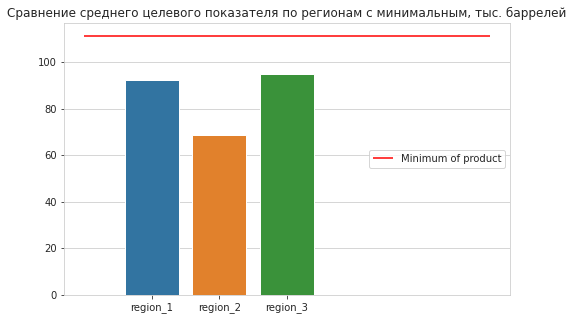

In [15]:
fig,ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=metrics_region.loc[['target_mean']])
ax.hlines(MIN_PRODUCT, -1, 5, color='r', label='Minimum of product')
plt.legend(loc='center right')
_ = ax.set_title('Сравнение среднего целевого показателя по регионам с минимальным, тыс. баррелей')

Судя по нашим вычислениям, ни один регион не предоставляет нужное кол-во сырья для того, чтобы выйти в прибыль. 

### Функция для расчета прибыли

In [16]:
# Напишем функцию для расчета прибыли в 200 скважинах с учетом затрат на разработки.
def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[predictions_sorted.index][:count]
    return ((selected.sum() * INCOME) - BUDGET) / 1e9
    
# Применим функцию на регионах.
region_revenue = []
for i in range(3):
    result = revenue(data[i]['product'], region_predictions[i], TOTAL_BEST_POINT)
    region_revenue.append(result)
    print('Прибыль в регионе {} - {:.2f} млрд. руб.'.format(i+1, result))


Прибыль в регионе 1 - 3.32 млрд. руб.
Прибыль в регионе 2 - 2.42 млрд. руб.
Прибыль в регионе 3 - 2.71 млрд. руб.


По результатам расчета, 1 регион оказался самым прибыльным.

## 4. Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [28]:
state=RandomState(12345)
def bootstrap (region):
    values=[]
    target=data[region]['product'].loc[region_predictions[region].index]
    
    for i in range(1000):
        target_subsample=target.sample(n=TOTAL_POINT, replace=True, random_state=state)
        predict_subsample=region_predictions[region][target_subsample.index]
        values.append(revenue(target_subsample, predict_subsample, TOTAL_BEST_POINT))
        
    values=pd.Series(values)    
    mean = values.mean()
    losk_risk=(values<0).mean()
    
    lower=values.quantile(0.025)
    upper=values.quantile(0.975)
    
    #tips = sns.load_dataset('tips')
    #ax = tips.plot(kind='hist', y='values', bins=30, ec='k', title='Распределение прибыли в регионах')
    #_ = ax.vlines(x = mean, ymin = lower, ymax = upper, colors='r')
    #plt.show()
    
    plt.figure(figsize=(13,8))
    sns.distplot(values, color='blue')
    plt.axvline(lower, color='black', linestyle=':')
    plt.axvline(mean, color='r')
    plt.axvline(upper, color='black', linestyle=':')
#     plt.title(name, fontsize=22)
    plt.xlabel('Прибыль, млн.руб.')
    plt.ylabel('Плотность распределения')
    plt.xlim(-2, 2)
    plt.show()
           
    return (mean, losk_risk, lower, upper)



In [26]:
import warnings
warnings.filterwarnings("ignore")

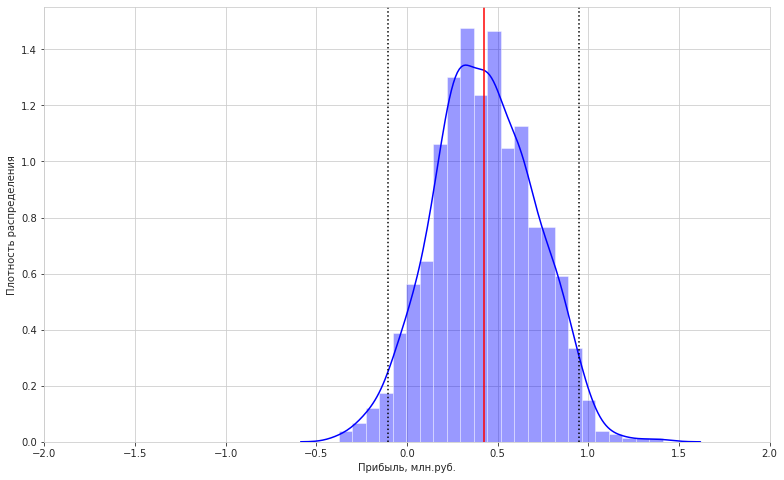

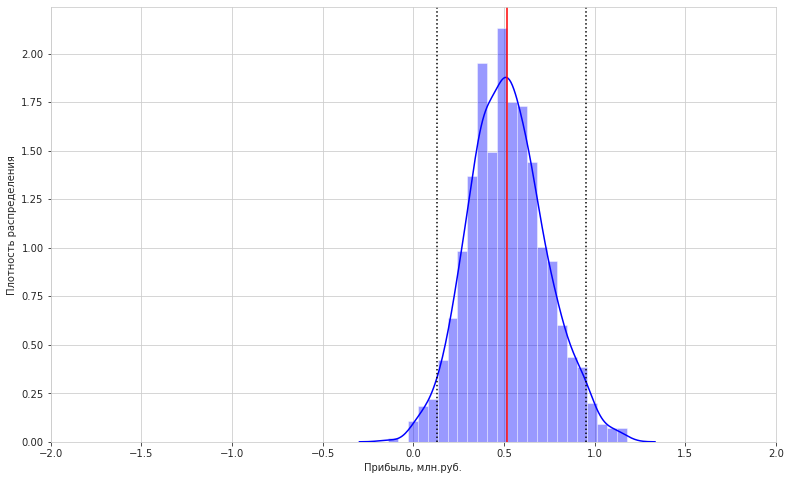

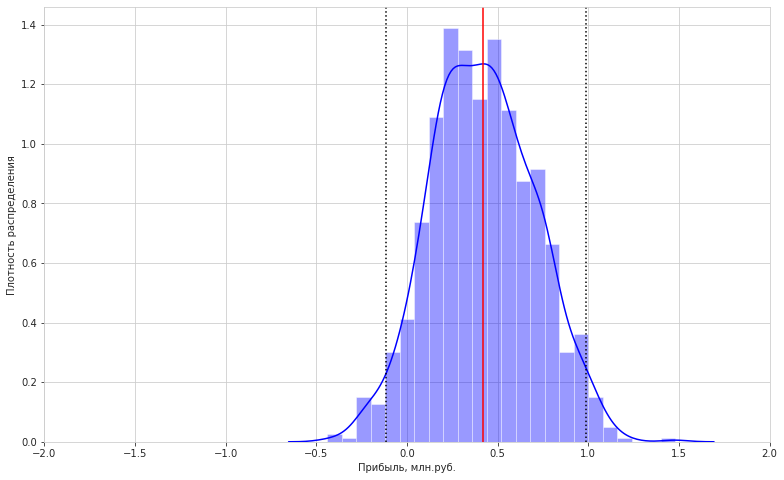

,mean,losk_risk,min_i,max_i
region1,0.425939,0.060,-0.102090,0.947976
region2,0.518259,0.003,0.128123,0.953613
region3,0.420194,0.062,-0.115853,0.989630


In [29]:
# Применим функцию к регионам
result=[]
for reg in range(3):
    result.append(bootstrap(reg))
    
# Соберем данные в таблицу
bootstrap_df=pd.DataFrame(data=result,
                          index=['region1', 'region2', 'region3'],
                          columns=['mean', 'losk_risk', 'min_i', 'max_i'])

bootstrap_df

In [21]:
# Теперь отфильтруем по максимальному риску
filtred_region=bootstrap_df.query('losk_risk < @MAX_RISK')
filtred_region

,mean,losk_risk,min_i,max_i
region2,0.518259,0.003,0.128123,0.953613


### Вывод

Подведем итог. Мы провели анализ регионов: посчитали доход, минимальный объем сырья для прибыли, посмотрели запасы сырья в разных регионах. 
- Ни один регион не обладает нужным запасом сырья.
- В каждом регионе видна положительная прибыль. 
   - Прибыль в регионе 1 - 3.32 млрд. руб.
   - Прибыль в регионе 2 - 2.42 млрд. руб.
   - Прибыль в регионе 3 - 2.71 млрд. руб.
- Минимальные границы доверительного интервала у 1 и 3 регионов выходят за пределы, в нужном интервале остался только 2 регион
- При сортировке районов по максимальному значению риска, 2 регион обладал подходящими параметрами. Риск = 0.003.

Однако, даже при удовлетворении всех параметров, 2 регион **не может быть рекомендован** ,так как его данные вызывают сомнения. Необходимо провести либо дополнительные анализы, либо уточнение данных. Можно было бы исключить этот регион, но тогда ни один из оставшихся регионов не подходит для разработки. 